# AI534 IA 4: Exploring word embeddings

**Overview**:
In this assignment, you will explore pre-trained word embeddings and use them to better understand textual data and improve downstream models.

Specifically, you will:
* Build a compact dataset of semantically related words using GloVe embeddings
* Cluster the word embeddings and compare different clustering metrics
* Visualize clusters using PCA and t-SNE
* (Bonus) Incorporate word embeddings or word-cluster representations into sentiment classification, building on your work in IA3

**What you need to submit**:
1. Your completed notebook in `.ipynb` format.
2. A PDF report that includes all code outputs and figures.

If some figures or outputs are missing in the PDF due to rendering/scrolling issues, manually add them (e.g., by inserting screenshots or exporting via another tool) so your PDF has all required results.

We have supplied auxiliary code for working with word embeddings. It is advisable to retain this code in its original form. Should you opt to modify this helper code, please ensure that your alterations are accompanied by comprehensive comments. This will facilitate your TA's understanding of the modifications and the rationale behind them.

In [1]:
# !pip install nbconvert > /dev/null 2>&1
# !pip install pdfkit > /dev/null 2>&1
# !apt-get install -y wkhtmltopdf > /dev/null 2>&1
import os
import pdfkit
import contextlib
import sys
# from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
# add more imports if necessary

# Background: Data and Word Embeddings

For the first part of this assignment, you will use GloVe, a word embedding model pre-trained on large corpora of unlabeled text. There are many other word embedding methods (see, for example, this overview: https://www.turing.com/kb/guide-on-word-embeddings-in-nlp), but here we will use GloVe embeddings (https://nlp.stanford.edu/projects/glove/).

Conceptually, in Part 1 you will treat words as the objects of interest and their GloVe embeddings as feature vectors describing them. These embeddings place words as points in a continuous “semantic” space, where semantically similar terms (such as *good* and *nice*) are located close to one another.

To avoid dealing with the full GloVe vocabulary, we provide a reduced file `GloVe_Embedder_data.txt` on Canvas. This file contains a subset of words from the IA3 sentiment dataset that also appear in the full GloVe vocabulary, along with their embeddings. Download this file and place it in the same Google Drive directory as the rest of your AI534 data so the notebook can access it.

If a word you encounter is not present in this embedding file, it will simply be treated as an unknown token by the helper code. This is expected behavior and does not require any special handling from you.

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# EMBEDDING_PATH = '/content/gdrive/My Drive/AI534/GloVe_Embedder_data.txt' #please do not modify this path

EMBEDDING_PATH = './GloVe_Embedder_data.txt' #please do not modify this path

In [3]:
# Helper class and functions --- Please leave as is.
# If you need to modify this block, please clearly indicate your change by providing detailed comments.
#
# Loads GloVe embeddings from a designated file location.
#
# Invoked via:
# ge = GloVe_Embedder(path_to_embeddings)
#
# Embed single word via:
# embed = ge.embed_str(word)
#
# Embed a list of words via:
# embeds = ge.embed_list(word_list)
#
# Find k nearest neighbors of word via:
# ge.find_k_nearest(word, k)
#
# Save vocabulary to file via:
# ge.save_to_file(path_to_file)

class GloVe_Embedder:
    def __init__(self, path):
        self.embedding_dict = {}
        self.embedding_array = []
        self.unk_emb = 0
        # Adapted from https://stackoverflow.com/questions/37793118/load-pretrained-GloVe-vectors-in-python
        with open(path,'r') as f:
            for line in f:
                split_line = line.split()
                word = split_line[0]
                embedding = np.array(split_line[1:], dtype=np.float64)
                self.embedding_dict[word] = embedding
                self.embedding_array.append(embedding.tolist())
        self.embedding_array = np.array(self.embedding_array)
        self.embedding_dim = len(self.embedding_array[0])
        self.vocab_size = len(self.embedding_array)
        self.unk_emb = np.zeros(self.embedding_dim)

    # Check if the provided embedding is the unknown embedding.
    def is_unk_embed(self, embed):
        return np.sum((embed - self.unk_emb) ** 2) < 1e-7

    # Check if the provided string is in the vocabulary.
    def token_in_vocab(self, x):
        if x in self.embedding_dict and not self.is_unk_embed(self.embedding_dict[x]):
            return True
        return False

    # Returns the embedding for a single string and prints a warning if
    # the string is unknown to the vocabulary.
    #
    # If indicate_unk is set to True, the return type will be a tuple of
    # (numpy array, bool) with the bool indicating whether the returned
    # embedding is the unknown embedding.
    #
    # If warn_unk is set to False, the method will no longer print warnings
    # when used on unknown strings.
    def embed_str(self, x, indicate_unk = False, warn_unk = True):
        if self.token_in_vocab(x):
            if indicate_unk:
                return (self.embedding_dict[x], False)
            else:
                return self.embedding_dict[x]
        else:
            if warn_unk:
                    print("Warning: provided word is not part of the vocabulary!")
            if indicate_unk:
                return (self.unk_emb, True)
            else:
                return self.unk_emb

    # Returns an array containing the embeddings of each vocabulary token in the provided list.
    #
    # If include_unk is set to False, the returned list will not include any unknown embeddings.
    def embed_list(self, x, include_unk = True):
        if include_unk:
            embeds = [self.embed_str(word, warn_unk = False).tolist() for word in x]
        else:
            embeds_with_unk = [self.embed_str(word, indicate_unk=True, warn_unk = False) for word in x]
            embeds = [e[0].tolist() for e in embeds_with_unk if not e[1]]
            if len(embeds) == 0:
                print("No known words in input:" + str(x))
                embeds = [self.unk_emb.tolist()]
        return np.array(embeds)

    # Finds the vocab words associated with the k nearest embeddings of the provided word.
    # Can also accept an embedding vector in place of a string word.
    # Return type is a nested list where each entry is a word in the vocab followed by its
    # distance from whatever word was provided as an argument.
    def find_k_nearest(self, word, k, warn_about_unks = True):
        if type(word) == str:
            word_embedding, is_unk = self.embed_str(word, indicate_unk = True)
        else:
            word_embedding = word
            is_unk = False
        if is_unk and warn_about_unks:
            print("Warning: provided word is not part of the vocabulary!")

        all_distances = np.sum((self.embedding_array - word_embedding) ** 2, axis = 1) ** 0.5
        distance_vocab_index = [[w, round(d, 5)] for w,d,i in zip(self.embedding_dict.keys(), all_distances, range(len(all_distances)))]
        distance_vocab_index = sorted(distance_vocab_index, key = lambda x: x[1], reverse = False)
        return distance_vocab_index[:k]

    def save_to_file(self, path):
        with open(path, 'w') as f:
            for k in self.embedding_dict.keys():
                embedding_str = " ".join([str(round(s, 5)) for s in self.embedding_dict[k].tolist()])
                string = k + " " + embedding_str
                f.write(string + "\n")

# Part 0(10 pts) : Build your data set of words for exploration.
In this part you will be a small data set of words and explore both clustering and dimension reduction on this data.

##🚧 Task: Build your own data set of words.
You will begin by constructing a compact dataset of words for visualization and experimentation.
Use the following seed words as your starting point:

**`flight`, `awesome`, `terrible`, `help`, `late`**

For each seed word:

* Retrieve the **30 nearest neighbor words** from the provided vocabulary (`GloVe_Embedder_data.txt`).
* Use the `find_k_nearest` function (Euclidean distance) to retrieve its nearest neighbors.  
  **Note:** `find_k_nearest` will return the seed word itself as one of the neighbors. Thus you can request **31 neighbors**, then **remove the seed word** from the result to obtain the desired **30 nearest neighbor words**.
* Store both the retrieved words and their embeddings.

If a word appears in the neighbor lists of multiple seed words, keep **one copy** of that word in your final dataset and assign it to the seed word to which it is **closest** (smallest distance).

This will give you **up to 150 unique words** (fewer if there is overlap), grouped into five clusters corresponding to the five seed words.

As a reference, display the 30 nearest neighbors for each seed word in a **dataframe**.


In [4]:
# Your code goes here
glove_embedder = GloVe_Embedder(EMBEDDING_PATH)

# Define seed words
seed_words = ['flight', 'awesome', 'terrible', 'help', 'late']

# Dictionary to store word -> (seed, distance) mapping
word_assignments = {}

# Dictionary to store neighbors for each seed word (for display)
seed_neighbors = {}

# For each seed word, find 31 nearest neighbors (including the seed itself)
for seed in seed_words:
    
    # Get 31 nearest neighbors (will include the seed word itself)
    neighbors = glove_embedder.find_k_nearest(seed, 31)

    # Remove the seed word itself (it will be the first neighbor with distance 0)
    neighbors_filtered = [n for n in neighbors if n[0] != seed][:30]
    
    # Store for display
    seed_neighbors[seed] = neighbors_filtered

    # For each neighbor, check if we should assign it to this seed
    for word, distance in neighbors_filtered:
        if word not in word_assignments:
            # First time seeing this word, assign it to this seed
            word_assignments[word] = (seed, distance)
        else:
            # Word already seen, keep it assigned to the closer seed
            existing_seed, existing_distance = word_assignments[word]
            if distance < existing_distance:
                word_assignments[word] = (seed, distance)

# Display the 30 nearest neighbors for each seed word
print("NEAREST NEIGHBORS FOR EACH SEED WORD")

for seed in seed_words:
    print(f"\n{seed.upper()}")
    print("-" * 70)
    
    # Create DataFrame for this seed's neighbors
    neighbors_data = {
        'Word': [n[0] for n in seed_neighbors[seed]],
        'Distance': [n[1] for n in seed_neighbors[seed]]
    }
    df = pd.DataFrame(neighbors_data)
    print(df.to_string(index=True))

# Group words by their assigned seed
final_clusters = {seed: [] for seed in seed_words}
for word, (seed, distance) in word_assignments.items():
    final_clusters[seed].append((word, distance))

# Create final embedding matrix and labels
word_list = []
embedding_list = []
label_list = []

for seed in seed_words:
    for word, distance in final_clusters[seed]:
        word_list.append(word)
        embedding_list.append(glove_embedder.embed_str(word))
        label_list.append(seed)

# Convert to numpy arrays
word_embeddings = np.array(embedding_list)
word_labels = np.array(label_list)

NEAREST NEIGHBORS FOR EACH SEED WORD

FLIGHT
----------------------------------------------------------------------
          Word  Distance
0        plane   4.45689
1      flights   5.32675
2     boarding   5.48820
3      airline   5.58355
4          jet   5.59065
5       flying   5.59299
6      heading   5.64170
7      arrival   5.70659
8     airlines   5.85213
9       travel   5.89098
10     shuttle   5.90023
11     delayed   5.91624
12     landing   5.92666
13       route   5.96298
14    airplane   6.00258
15        safe   6.00877
16     booking   6.01374
17         fly   6.02409
18   departure   6.04052
19     waiting   6.04259
20      landed   6.09697
21     journey   6.12156
22  passengers   6.12345
23     transit   6.12451
24       delay   6.13663
25        crew   6.14757
26       pilot   6.17311
27        trip   6.18669
28        taxi   6.20436
29        next   6.20817

AWESOME
----------------------------------------------------------------------
          Word  Distance
0   

# Part 1 (35pts): Clustering the words

##🚧 (15 pts) Task 1.1: Kmeans objective as a function of $k$
Apply the k-means clustering algorithm to your word-embedding dataset using a range of cluster counts.  
Use `sklearn.cluster.KMeans` and keep the default settings **except** for `n_clusters`.

For each value of \(k\) from **2 to 20**:

* Fit a k-means model to your word embeddings.
* Record the **k-means objective** (the `inertia_` attribute in scikit-learn), defined as  
  $$
  \sum_{i=1}^k \sum_{x \in C_i} \|x - \mu_i\|^2 .
  $$

Finally, **plot the k-means objective as a function of \(k\)**.  
Include clear axis labels and a descriptive title.


K-MEANS CLUSTERING: COMPUTING OBJECTIVES


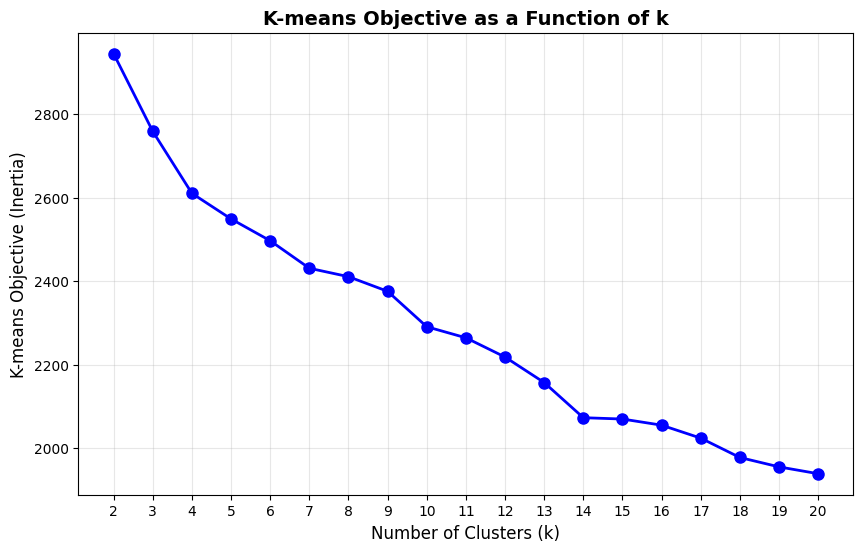

In [5]:
# Your code goes here
# Store k values and corresponding inertia (k-means objective)
k_values = range(2, 21)
inertias = []

print("K-MEANS CLUSTERING: COMPUTING OBJECTIVES")

# Fit k-means for each value of k from 2 to 20
for k in k_values:
    # Fit k-means with default settings except n_clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(word_embeddings)
    
    # Record the inertia (k-means objective)
    inertias.append(kmeans.inertia_)

# Plot k-means objective as a function of k
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('K-means Objective (Inertia)', fontsize=12)
plt.title('K-means Objective as a Function of k', fontsize=14, fontweight='bold')
plt.xticks(k_values)
plt.grid(True, alpha=0.3)

##✍️ **Question:**
1. Is the k-means objective strictly decreasing as \(k\) increases? In practice you may observe some deviations from monotonic decrease, explain why they may occur?

2. Does the plotted curve provide any evidence that \(k = 5\) might be a reasonable number of clusters for this dataset? Discuss your reasoning.

**1.- The k-means objective is monotonically decreasing as k increases. Deviations from this monotonic decrease, can stem from the fact that K-means is not guaranteed to converge to the global optimum. Additionally, since K-means uses randomly initialized centers, this can also mean we get an unlucky initialization that converges to a "bad" local minimum.**

**2.- Looking at the plot we see that the k-means objective keeps going down at a linear rate after k=5, thus there is no diminishing returns after k=5. This means we can still choose a higher k to get better performance. A better choice of k would be k=14, as we can clearly see an "elbow" in the graph where higher values of k provide less and less improvements on the objective.**

## 🚧 (20 pts) Task 1.2: evaluating your clustering against ground truth (20 pts)
Use the original seed-word assignments as **ground-truth labels** for your dataset, and evaluate the quality of your k-means clustering results for different values of \(k\).
**Reminder:** The ground-truth label for each word is the seed word whose neighbor list it came from (after resolving any overlaps using the distance rule from Task 1.1).
For each \(k\) from **2 to 20**, compute the following metrics:

- **Purity** (You must implement this metric yourself.)
- **Adjusted Rand Index (ARI)**  Use `sklearn.metrics.adjusted_rand_score`.
- **Normalized Mutual Information (NMI)** Use `sklearn.metrics.normalized_mutual_info_score`.

Plot each metric as a function of \(k\).  
Be sure to label axes clearly and provide legends where appropriate.





In [6]:
# Your code goes here.
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from collections import Counter

def compute_purity(true_labels, cluster_labels):
    """
    Compute the purity of clustering results.
    
    Purity = (1/N) * sum over clusters of max count of true labels in each cluster
    
    Args:
        true_labels: ground truth labels
        cluster_labels: predicted cluster assignments
    
    Returns:
        purity score (between 0 and 1, higher is better)
    """
    # Total number of samples
    n_samples = len(true_labels)
    
    # Get unique cluster IDs
    unique_clusters = np.unique(cluster_labels)
    
    # For each cluster, count the most common true label
    total_correct = 0
    for cluster_id in unique_clusters:
        # Get indices of points in this cluster
        cluster_mask = cluster_labels == cluster_id
        # Get true labels for points in this cluster
        true_labels_in_cluster = true_labels[cluster_mask]
        # Count occurrences of each true label
        label_counts = Counter(true_labels_in_cluster)
        # Add the count of the most common label
        most_common_count = label_counts.most_common(1)[0][1]
        total_correct += most_common_count
    
    purity = total_correct / n_samples
    return purity

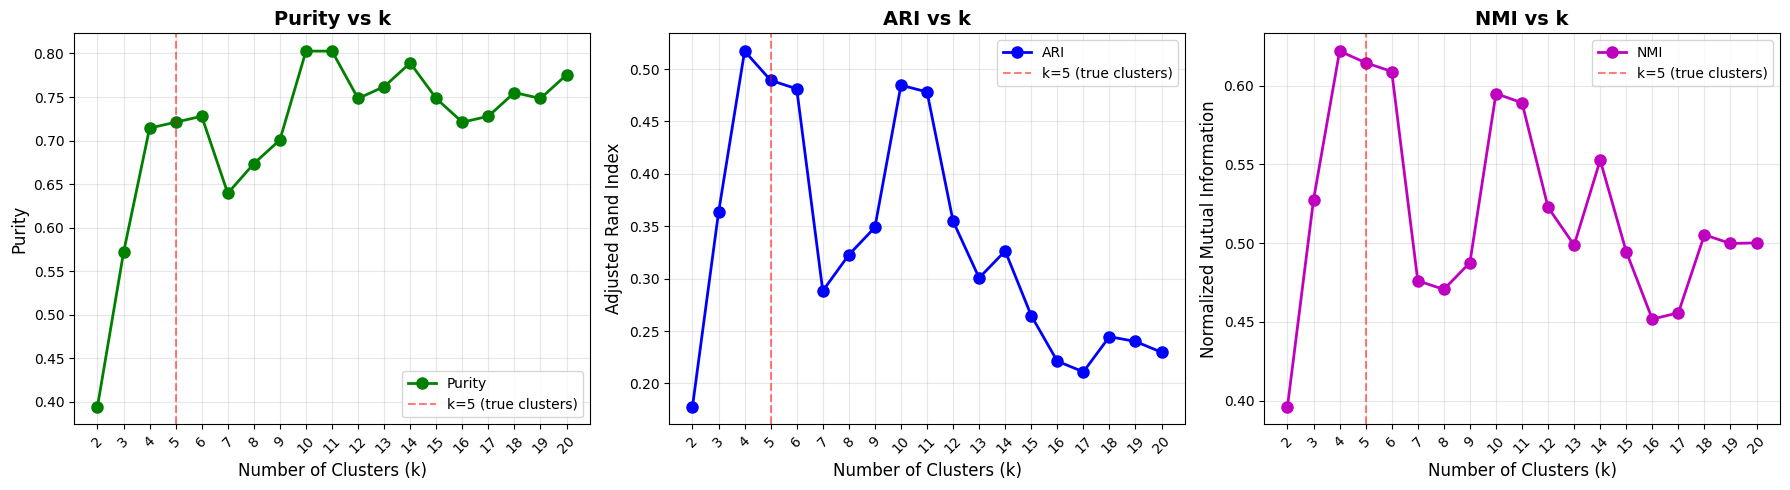

In [7]:
# Store metrics for each k
k_values = range(2, 21)
purity_scores = []
ari_scores = []
nmi_scores = []

# For each k, fit k-means and compute metrics
for k in k_values:
    # Fit k-means
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(word_embeddings)
    
    # Compute purity (custom implementation)
    purity = compute_purity(word_labels, cluster_labels)
    purity_scores.append(purity)
    
    # Compute ARI
    ari = adjusted_rand_score(word_labels, cluster_labels)
    ari_scores.append(ari)
    
    # Compute NMI
    nmi = normalized_mutual_info_score(word_labels, cluster_labels)
    nmi_scores.append(nmi)

# Plot all three metrics as a function of k
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Purity
axes[0].plot(k_values, purity_scores, 'go-', linewidth=2, markersize=8, label='Purity')
axes[0].axvline(x=5, color='red', linestyle='--', alpha=0.5, label='k=5 (true clusters)')
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Purity', fontsize=12)
axes[0].set_title('Purity vs k', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[0].set_xticks(k_values)
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Adjusted Rand Index
axes[1].plot(k_values, ari_scores, 'bo-', linewidth=2, markersize=8, label='ARI')
axes[1].axvline(x=5, color='red', linestyle='--', alpha=0.5, label='k=5 (true clusters)')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Adjusted Rand Index', fontsize=12)
axes[1].set_title('ARI vs k', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
axes[1].set_xticks(k_values)
axes[1].tick_params(axis='x', rotation=45)

# Plot 3: Normalized Mutual Information
axes[2].plot(k_values, nmi_scores, 'mo-', linewidth=2, markersize=8, label='NMI')
axes[2].axvline(x=5, color='red', linestyle='--', alpha=0.5, label='k=5 (true clusters)')
axes[2].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[2].set_ylabel('Normalized Mutual Information', fontsize=12)
axes[2].set_title('NMI vs k', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].legend()
axes[2].set_xticks(k_values)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

##✍️ **Question:**

1. Based on the three evaluation metrics (Purity, ARI, NMI), does \(k = 5\) appear to give the best scores? Comment on how each metric behaves as \(k\) varies, and explain why the “best” value of \(k\) may or may not align with the true number of clusters in the data.

2. Suppose you want to compare **two different clustering algorithms**, each of which automatically chooses its own number of clusters (for example, one may return 5 clusters while the other returns 10). Among Purity, ARI, and NMI, which metric(s) are appropriate for comparing their performance?  Explain your reasoning—particularly how each metric handles differences in the number of clusters.

**1.- Based on the plots, a k=5 does not give the best scores in any of the metrics. Purity actually keeps increasing after k=5, since with more clusters, it becomes easier to achieve "pure" clusters where most points share the same ground truth label. The ARI metric has a peak around k=5, which indicates a high agreement between the ground truth clusters and the learned clustering. As k increases the ARI metric steadily goes down, peaks again at k=10 and then keeps decreasing. The NMI metric shows a similar behavior to the ARI metric, it also peaks around k=5, then again at k=10, and the keeps decreasing as k increases.**

**According to the ARI and NMI metric the best k would be k=4. Even though we know the ground truth to be k=5. This can happen since there can be overlap between words such as "flight" and "late" which are related to travel. Additionally, since K-means assumes spherical and equal-variance clusters, the word embeddings may form regions that do not match these assumptions.**

**2.-I wouldn't use purity, since it is rewarding higher values of k regardless of the ground truth. Thus the algorithm that returns 10 clusters will always have higher purity regardless of how good the clustering actually is.**

**ARI accounts for random clustering and it doesn't reward having more clusters. It will provide a better comparison metric since it accounts for the expected overlap due to randomness.**

**NMI measures how much information one clustering provides about the other, ignoring the actual cluster count, and as we saw in the plots shows very similar behavior to ARI when k changes. For these reasons I would use either ARI or NMI.**



# Part 2 (35 pts): Dimension reduction and visualization
In this part, you will reduce the dimension of your data to 2-d using PCA and t-SNE and visualize them.

## 🚧  (15 pts) Task 2.1: apply PCA dimension reduction

1. Apply **Principal Component Analysis (PCA)** to your word-embedding dataset using  
`sklearn.decomposition.PCA` and project the embeddings into **2 dimensions**.

2. Create a **2D scatter plot** of the PCA-reduced embeddings using `matplotlib`, using **different colors** to indicate the cluster associated with each seed word (i.e., the seed word from which each neighbor originated).
4. Annotate a **selected set of words**—including some from well-separated regions and some from visually overlapping regions—so the plot is easier to interpret. Use the `annotate` function from `matplotlib` to label the chosen points.

Your plot should include:
* Axis labels (e.g., “PC1”, “PC2”)  
* A legend mapping colors to seed-word clusters  
* A descriptive title

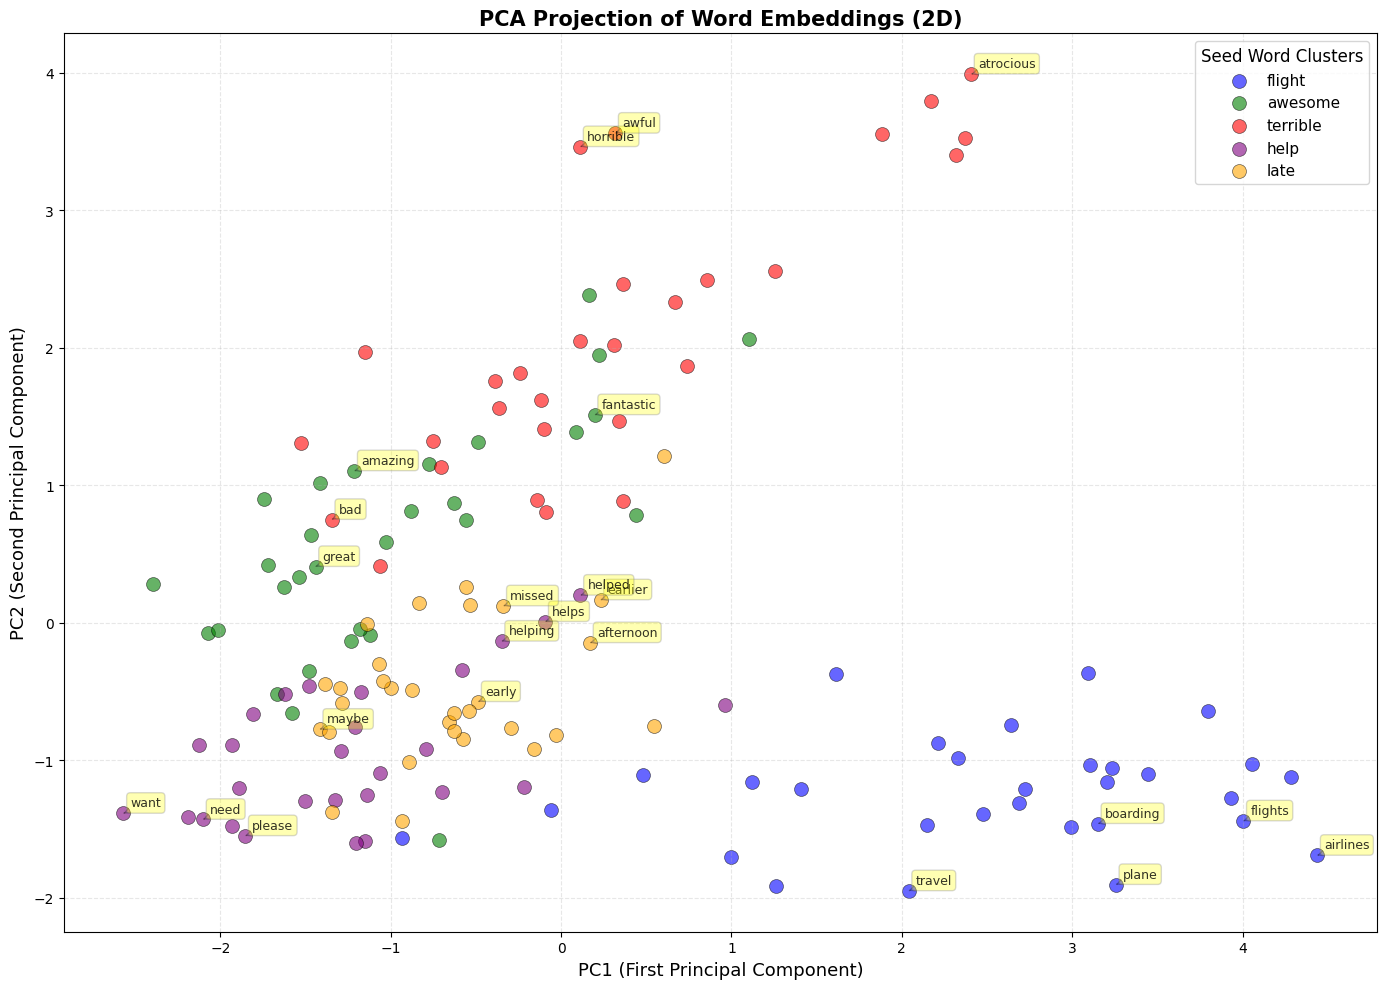

In [13]:
# Your code goes here.
from sklearn.decomposition import PCA

# Apply PCA to reduce embeddings to 2 dimensions
pca = PCA(n_components=2, random_state=42)
word_embeddings_pca = pca.fit_transform(word_embeddings)

# Create color map for seed words
seed_colors = {
    'flight': 'blue',
    'awesome': 'green',
    'terrible': 'red',
    'help': 'purple',
    'late': 'orange'
}

# Create the scatter plot
plt.figure(figsize=(14, 10))

# Plot points for each seed word cluster
for seed in seed_words:
    # Get indices of words belonging to this seed
    mask = word_labels == seed
    plt.scatter(
        word_embeddings_pca[mask, 0],
        word_embeddings_pca[mask, 1],
        c=seed_colors[seed],
        label=seed,
        alpha=0.6,
        s=100,
        edgecolors='black',
        linewidth=0.5
    )

# Select words to annotate
# Strategy: Pick words from different regions of the plot
words_to_annotate = []

# Get a few words from each cluster
for seed in seed_words:
    cluster_words = [w for w, l in zip(word_list, word_labels) if l == seed]
    words_to_annotate.extend(cluster_words[:3])  # First 3 from each cluster

# Find words at extremes (well-separated) and center (overlapping)
pc1_coords = word_embeddings_pca[:, 0]
pc2_coords = word_embeddings_pca[:, 1]

# Add extreme words (well-separated regions)
extreme_indices = [
    np.argmin(pc1_coords),  # Leftmost
    np.argmax(pc1_coords),  # Rightmost
    np.argmin(pc2_coords),  # Bottom
    np.argmax(pc2_coords)   # Top
]

for idx in extreme_indices:
    if word_list[idx] not in words_to_annotate:
        words_to_annotate.append(word_list[idx])

# Add words near center (overlapping regions)
center_dist = np.sqrt(pc1_coords**2 + pc2_coords**2)
central_indices = np.argsort(center_dist)[:5]
for idx in central_indices:
    if word_list[idx] not in words_to_annotate and len(words_to_annotate) < 25:
        words_to_annotate.append(word_list[idx])

# Annotate selected words
for word in words_to_annotate:
    if word in word_list:
        idx = word_list.index(word)
        plt.annotate(
            word,
            xy=(word_embeddings_pca[idx, 0], word_embeddings_pca[idx, 1]),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=9,
            alpha=0.8,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3, edgecolor='gray'),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', alpha=0.3)
        )

plt.xlabel('PC1 (First Principal Component)', fontsize=13)
plt.ylabel('PC2 (Second Principal Component)', fontsize=13)
plt.title('PCA Projection of Word Embeddings (2D)', fontsize=15, fontweight='bold')
plt.legend(title='Seed Word Clusters', fontsize=11, title_fontsize=12, loc='best')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

##✍️ **Question**: Reflection on PCA results
Does the 2-D PCA visualization reveal **five clearly separated clusters**?  
Describe where clusters appear well-separated and where they overlap or mix.  
In your discussion, consider that both the underlying word embeddings **and** the PCA projection to 2-D can influence the amount of visible separation.

**The clusters are not all clearly separated. The two clusters that have the most visible separation are the "flight" and "terrible" clusters as they are the furthest from the rest of the clusters. The rest of the clusters "late", "help", and "awesome" overlap. Where the "help" and "late" clusters are the most heavily overlapped.**

**The GloVe embeddings dimensionality is one of the causes for the overlap. These embeddings capture semantic similarity in high-dimensional space. Thus, words with overlapping usage contexts naturally cluster together in this space. Additionally, PCA is doing a linear projection from a high dimensional space to 2-D preserving only the directions of maximum variance. This inevitably causes loss of information that exist in higher dimensions may collapse when reduced to 2-D.**

## 🚧(20 pts) Task 2.2: apply t-SNE

Now apply **t-SNE**, a nonlinear dimensionality-reduction method, to your word-embedding dataset.  
Use `sklearn.manifold.TSNE` with **Euclidean distance** to project the embeddings into **2 dimensions**.

t-SNE is sensitive to its **perplexity** parameter. The original authors recommend values between 5 and 50, so for this assignment you should run t-SNE using the following perplexities:

**5, 10, 20, 30, 40, 50**

For each chosen perplexity:

1. Compute the 2-D t-SNE embedding.  
2. Create a **2D scatter plot** using the same color scheme as in the PCA task (one color per seed-word cluster).  
3. Annotate a **selected set of words** that help you interpret the visualization—include examples from **well-separated** regions and **visually overlapping** regions.  
   Use the `annotate` function from `matplotlib` for labeling points.

Your plots should include:
* Axis labels (e.g., “t-SNE dim 1”, “t-SNE dim 2”)  
* A legend mapping colors to seed-word clusters  
* A descriptive title indicating the perplexity used

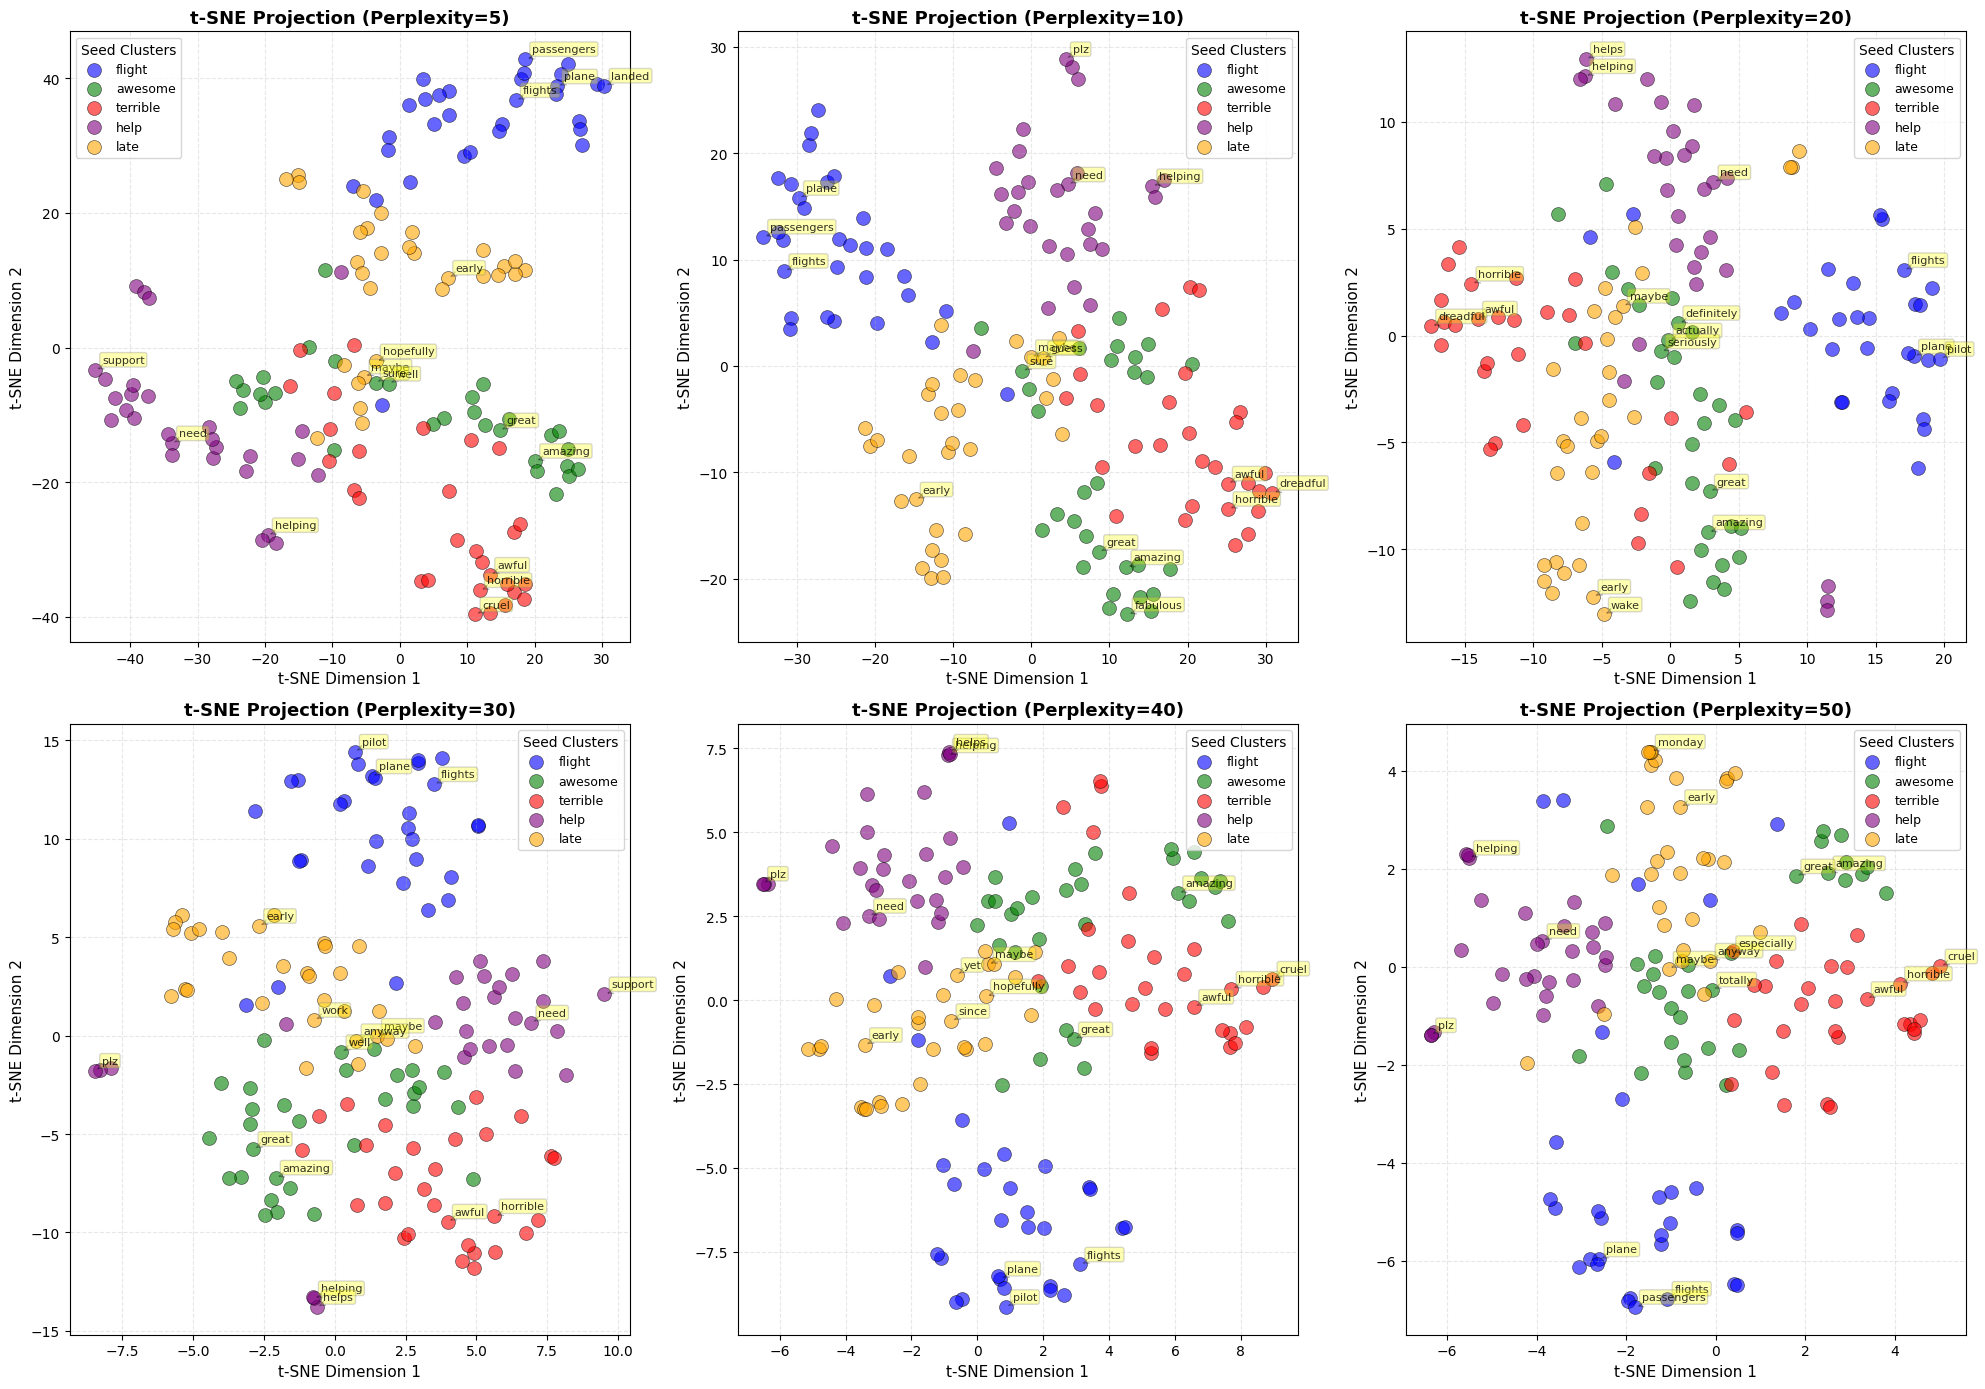

t-SNE visualizations complete!


In [15]:
# Your code goes here
from sklearn.manifold import TSNE

# Perplexity values to test
perplexities = [5, 10, 20, 30, 40, 50]

# Create a figure with subplots for all perplexities
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
axes = axes.flatten()

for idx, perplexity in enumerate(perplexities):
    
    # Apply t-SNE with current perplexity
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, metric='euclidean')
    word_embeddings_tsne = tsne.fit_transform(word_embeddings)
    
    # Plot on the corresponding subplot
    ax = axes[idx]
    
    # Plot points for each seed word cluster
    for seed in seed_words:
        mask = word_labels == seed
        ax.scatter(
            word_embeddings_tsne[mask, 0],
            word_embeddings_tsne[mask, 1],
            c=seed_colors[seed],
            label=seed,
            alpha=0.6,
            s=100,
            edgecolors='black',
            linewidth=0.5
        )
    
    # Select words to annotate
    words_to_annotate = []
    
    # Get a few words from each cluster
    for seed in seed_words:
        cluster_words = [w for w, l in zip(word_list, word_labels) if l == seed]
        words_to_annotate.extend(cluster_words[:2])  # First 2 from each cluster
    
    # Find words at extremes (well-separated) and center (overlapping)
    tsne1_coords = word_embeddings_tsne[:, 0]
    tsne2_coords = word_embeddings_tsne[:, 1]
    
    # Add extreme words (well-separated regions)
    extreme_indices = [
        np.argmin(tsne1_coords),  # Leftmost
        np.argmax(tsne1_coords),  # Rightmost
        np.argmin(tsne2_coords),  # Bottom
        np.argmax(tsne2_coords)   # Top
    ]
    
    for extreme_idx in extreme_indices:
        if word_list[extreme_idx] not in words_to_annotate:
            words_to_annotate.append(word_list[extreme_idx])
    
    # Add words near center (overlapping regions)
    center_dist = np.sqrt(tsne1_coords**2 + tsne2_coords**2)
    central_indices = np.argsort(center_dist)[:3]
    for central_idx in central_indices:
        if word_list[central_idx] not in words_to_annotate and len(words_to_annotate) < 20:
            words_to_annotate.append(word_list[central_idx])
    
    # Annotate selected words
    for word in words_to_annotate:
        if word in word_list:
            word_idx = word_list.index(word)
            ax.annotate(
                word,
                xy=(word_embeddings_tsne[word_idx, 0], word_embeddings_tsne[word_idx, 1]),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8,
                alpha=0.8,
                bbox=dict(boxstyle='round,pad=0.2', facecolor='yellow', alpha=0.3, edgecolor='gray'),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', alpha=0.3)
            )
    
    ax.set_xlabel('t-SNE Dimension 1', fontsize=11)
    ax.set_ylabel('t-SNE Dimension 2', fontsize=11)
    ax.set_title(f't-SNE Projection (Perplexity={perplexity})', fontsize=13, fontweight='bold')
    ax.legend(title='Seed Clusters', fontsize=9, title_fontsize=10, loc='best')
    ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("t-SNE visualizations complete!")

##✍️ **Question: Reflection on t-SNE results**

Across the different perplexity settings, do the 2-D t-SNE visualizations reveal distinct clusters?
Describe where clusters appear well separated and where they overlap or mix, and how this changes with perplexity.
Comment on how the perplexity parameter influences the visible structure.

 **Your answe goes here.**

##✍️ Question: PCA vs. t-SNE
Compare your PCA and t-SNE visualizations.
Which method provides clearer separation between clusters, and in what ways do their results differ?
Discuss how PCA’s linear projection and t-SNE’s emphasis on local neighborhoods may explain the differences you observe.

# Optional Part 3 (Up to 30 bonus pts): Using word embeddings to improve tweet classification

In this bonus task, you will return to the **sentiment classification dataset** used in IA3 and explore how to improve the basic bag-of-words (BoW) representation by leveraging **word embeddings**.

Your goal is to answer the following question:

> **How can word embeddings be used to create a more effective representation of tweets for classification?**

You should continue using classifiers covered in this course (e.g., logistic regression, naive Bayes, SVM, k-NN, tree-based models).  
**Do not use deep learning models** for this bonus task.

Because the dataset is heavily imbalanced (≈80% negative, ≈20% positive), use **Area Under the ROC Curve (AUC)** (`sklearn.metrics.roc_auc_score`) on the validation data as your primary performance metric.



## 🌱 Seed ideas.

Below are two example directions. You may explore one of these or propose your own.

---

### **Idea 1: Embedding-based averaged representations**

Represent a tweet as the **weighted average** of its word embeddings.  
For example:
- Weight each word via its (normalized) tf-idf value.
- Average the weighted embeddings to obtain a dense, low-dimensional vector.

This can reduce dimensionality and potentially improve generalization.

---

### **Idea 2: Bag-of-word-clusters (with optional bi-clusters)**

BoW treats semantically similar words as unrelated.  
To reduce redundancy:

- Cluster the vocabulary based on word embeddings (e.g., k-means).
- Replace each word in a tweet with its **cluster ID** to form a bag-of-cluster representation.

**Optional extension:**  
Consider the benefit of bigram features in IA3, you could also consider mapping bigrams to **bi-clusters**:
- For a bigram *(w₁, w₂)*, replace it with the pair *(cluster(w₁), cluster(w₂))*.
- Build a bag-of-bi-clusters representation.

This preserves some local structure while greatly reducing feature dimensionality.

---


## 💯 Bonus Point Structure (up to 30 points)
Your bonus points will be awarded in three tiers:

#### **Tier 1 — Basic implementation (10 pts)**  
Awarded if you:
- Implement one valid idea correctly.
- Train at least one classifier on your new representation.
- Report training and validation AUC.
- Provide a brief description of your approach.

#### **Tier 2 — Thoughtful exploration (10 pts)**  
Awarded for going beyond the basics by doing **one or more** of:
- Exploring meaningful hyperparameter variations  
  (e.g., number of clusters, tf-idf weighting schemes, classifier choices).
- Providing informative comparisons or plots.
- Offering a clear interpretation of overfitting/underfitting behavior.
- Trying multiple variants within your chosen idea.

#### **Tier 3 — Insightful extension (10 pts)**  
Awarded for deeper insight or creative extensions, such as:
- Incorporating **bi-clusters** or combining embedding-based ideas in a justified way.
- Providing a well-reasoned explanation of how the representation influences classifier behavior.
- Discussing limitations or failure modes.
- Presenting a well-organized, thoughtful mini-report.

**Total possible bonus: 30 points**



## 🚧 What to do

Choose **one main idea** and explore it.  
You may try different variants of your chosen idea (e.g., number of clusters, weighting schemes, classifiers), and you **may** explore more than one idea if you wish, **but this is not required**.  As indicated by the bonus point struture, the bonus credit is awarded based on the **quality and depth** of your exploration, not the number of ideas attempted.

You may use any classifier covered in this course.

You are **not required** to achieve improved validation performance compared to IA3.

Include your code (below) in this notebook and provide a brief report.
---

In [10]:
# Your code goes here


## ✍️ Bonus-part report.
Your report should:

1 Describes your idea (including any hyperparameters or variants you explored).

2. Summarizes your results (training and validation performance, using AUC as the main metric).

3. Interprets the results. For example: How did your representation affect overfitting/underfitting compared to BoW? Did the embedding-based features change the classifier’s behavior or sensitivity?

Your report goes here.

In [11]:
#running this code block will convert this notebook and its outputs into a pdf report.
!jupyter nbconvert --to html /content/gdrive/MyDrive/Colab\ Notebooks/IA4-2024.ipynb  # you might need to change this path to appropriate value to location your copy of the IA0 notebook

input_html = '/content/gdrive/MyDrive/Colab Notebooks/IA4-2024.html' #you might need to change this path accordingly
output_pdf = '/content/gdrive/MyDrive/Colab Notebooks/IA4output.pdf' #you might need to change this path or name accordingly

# Convert HTML to PDF
pdfkit.from_file(input_html, output_pdf)

# Download the generated PDF
files.download(output_pdf)

[NbConvertApp] WARNING | pattern '/content/gdrive/MyDrive/Colab Notebooks/IA4-2024.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--Jupy

OSError: No such file: /content/gdrive/MyDrive/Colab Notebooks/IA4-2024.html